# Multi-Class Lung Disease Classification - DenseNet121 Final Training with Optimized Architecture & Optimization Strategy

<div style="text-align: center;">
    <img src="../images/lung.webp" alt="Medical AI" style="display: block; margin: 0 auto;">
</div>

## Overview

This notebook performs the **final supervised training** of a multi-class lung disease classification model based on **DenseNet121**, using **previously optimized configurations** obtained from a structured Optuna research workflow.

All architectural and optimization choices used here are **fixed and validated**.  
The focus of this notebook is **stable training, correct data handling, and meaningful evaluation**, rather than experimentation.

---

## Research Context (What Happened Before)

Before this stage, the project followed a **two-phase optimization process**:

### **Phase 1 – Classifier Head Architecture Search**
- DenseNet121 backbone kept frozen
- Search over:
  - Number of dense layers
  - Units per layer
  - With low fixed Dropout
- Goal: find a classifier head that works *with* DenseNet features, not against them

### **Phase 2 – Optimization & Training Behavior Search**
- Best architecture fixed
- Optimization-focused tuning including:
  - Learning rate and weight decay
  - Dropout strength
  - **Class-weight scaling behavior**
  - Training stability signals

This notebook **reuses the best configurations discovered in those phases** and applies them to train the final model.

## Class Imbalance Handling (Weighted but Controlled)

Class imbalance is handled using **computed class weights**, derived directly from the dataset distribution.

Instead of always applying raw inverse-frequency weights, a **weight-scaling power parameter** (searched during Phase 2) is applied:

- Weight power = 0 → all classes treated equally  
- Weight power = 1 → full raw class weighting  
- Intermediate values → smooth interpolation between the two

This allows the model to benefit from imbalance correction **without over-amplifying minority classes**, and the selected value is loaded as part of the optimized training configuration.

## Model & Training Design

- **Backbone**: DenseNet121 pretrained on ImageNet  
  - Loaded without the top classifier  
  - BatchNormalization layers kept frozen during fine-tuning

- **Classifier Head**:
  - Architecture fixed from Phase 1
  - Dropout behavior aligned with the optimization phase
  - Softmax output for multi-class prediction

- **Loss & Optimization**:
  - Categorical cross-entropy
  - AdamW optimizer
  - Learning rate scheduling for smooth convergence

## Monitoring Overfitting & Class-Level Behavior

In addition to standard validation metrics, training is monitored using **custom diagnostic callbacks** designed to provide better intuition:

- **Overfitting detection**  
  Training can be halted early when the gap between training and validation loss exceeds a defined threshold for multiple epochs, signaling consistent overfitting rather than noise.

- **Per-class performance tracking**  
  Precision, recall, and F1-score are periodically computed **per class** on the validation set, making it easier to spot:
  - Classes that are being ignored
  - Precision–recall trade-offs
  - Imbalance-driven failure modes

These signals are used for **interpretation and confidence**, not as optimization targets.

## Data Pipeline Summary

- TFRecord-based input pipeline
- Lung ROI extraction using segmentation masks
- Class filtering and remapping for clean multi-class learning
- One-hot encoded labels
- ImageNet-compatible preprocessing
- Augmentation applied only during training

This keeps the learning signal focused on **lung regions** while maintaining consistency across splits.

## Final Objective

The goal of this notebook is simple and explicit:

> Train the best-known configuration cleanly and transparently, and understand how it behaves at both the global and per-class level.

The resulting model is suitable for:
- Evaluation
- Comparison against baselines
- Downstream integration (handled separately)


## Section 1 - Environment Setup, Imports, and Reproducibility

This section initializes the training environment and ensures reproducibility across runs.

It includes:
- Core scientific and visualization libraries
- TensorFlow / Keras components required for model definition and training
- Optimizer, loss, and learning rate scheduling utilities
- Custom helper functions imported from the project `utils` module

The section also enforces deterministic behavior by fixing random seeds and configuring
hardware-related settings such as GPU memory growth and distributed training strategy.


### 1.1 Library Imports

All required libraries for model training, evaluation, and logging are imported here.
This includes TensorFlow/Keras components, metric utilities, visualization tools,
and project-specific helper functions.

In [5]:
# ------------------------------
# Core Python & Scientific Stack
# ------------------------------
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------------------
# Metrics & Evaluation Utilities
# ------------------------------
from sklearn.metrics import precision_recall_fscore_support

# ------------------------------
# TensorFlow / Keras Core
# ------------------------------
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow.keras.layers as tfl
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.metrics as metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay

# ------------------------------
# Project Utilities
# ------------------------------
# Contains data pipelines, model builders, callbacks, and reproducibility helpers
from utils import *

### 1.2 Framework Version Verification

The TensorFlow version is printed explicitly to document the exact framework
used during training, which is important for reproducibility and future reference.

In [2]:
# ------------------------------------------------
# Verify TensorFlow version for reproducibility
# ------------------------------------------------
print(f"TensorFlow / Keras Version: {tf.__version__}")

TensorFlow / Keras Version: 2.20.0


---
### 1.3 Reproducibility and Hardware Strategy

This subsection enforces deterministic behavior and configures the execution strategy:

- A fixed random seed is applied across TensorFlow, NumPy, and Python
- GPU memory growth is enabled to prevent TensorFlow from pre-allocating all memory
- The best available distributed strategy is selected automatically (TPU, multi-GPU, or CPU)

These steps ensure stable experiments and scalable training across different environments.

In [3]:
# ------------------------------------------------
# Global reproducibility & hardware configuration
# ------------------------------------------------
SEED = 28

# Ensure deterministic behavior across runs
seed_everthing(SEED)

# Enable dynamic GPU memory allocation (prevents OOM at startup)
gpu_growth()

# Select the best available execution strategy (TPU > GPU > CPU)
strategy = get_strategy()

For reproducibility, everything seeded!
Enabled memory growth for 1 GPU(s)
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU strategy: MirroredStrategy
REPLICAS: 1


I0000 00:00:1768245248.856364   15847 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


---
## Section 2 -  Global Configuration and Experiment Setup

This section defines all **global constants and configuration values** used throughout training.

The goal is to make the notebook:
- Easy to read
- Easy to reproduce
- Easy to modify without touching core logic

All dataset, model, logging, and training-related parameters are centralized here,
so downstream code remains clean and declarative.


### 2.1 Dataset, Training, and Runtime Configuration

This subsection defines all core constants related to:

- Data loading and parallelism
- Image and mask resolution
- Training schedule and batch sizing
- Class structure and overfitting sensitivity

The global batch size is scaled automatically using the number of synchronized
replicas:

$$
B_{\text{global}} = B_{\text{per-replica}} \times N_{\text{replicas}}
$$

This ensures consistent optimization behavior across single-device and distributed
training setups.


In [4]:
AUTO = tf.data.AUTOTUNE  # Enables dynamic parallelism for tf.data pipelines

DATA_DIR = '../data/tfrecords'  # Root directory containing TFRecord files
MODELS_DIR = '../models/classification/'  # Where trained models are saved
LOG_DIR = '../logs/classification/densenet/'  # TensorBoard log directory
BEST_TRIAL_DIR = './optuna/phase2_optimization/best_hparams.json'  # Optimized hparams

UNFREEZE_LAYER = 'conv5_block1_0_bn'  # First layer to unfreeze during fine-tuning

IMG_SIZE = (256, 256)  # Input image resolution
MASK_SIZE = IMG_SIZE   # Mask resolution aligned with image size

SHUFFLE_SIZE = 1024  # Buffer size for dataset shuffling
OVERFIT_THRESHOLD = 0.03  # Max acceptable (val_loss - train_loss) gap

NUM_CLASSES = 3  # Number of target disease classes
WARMUP_EPOCH = 5  # Epochs with frozen backbone
FINAL_EPOCH = 50  # Total training epochs

BATCH_SIZE_PER_REPABLICA = 8  # Per-device batch size
BATCH_SIZE = BATCH_SIZE_PER_REPABLICA * strategy.num_replicas_in_sync
print(f"Global Batch Size: {BATCH_SIZE}")

MODEL_CONFIG = {
    "img_size": IMG_SIZE,
    "mask_size": MASK_SIZE,
    "num_classes": NUM_CLASSES
}

DATASET_CONFIG = {
    "batch_size": BATCH_SIZE,
    "shuffle": SHUFFLE_SIZE,
    "auto": AUTO
}


Global Batch Size: 8


### 2.2 Model and Artifact Paths

File paths for warm-up and final training checkpoints are defined explicitly.
This separates intermediate training artifacts from the final model used for evaluation
or downstream integration.


In [5]:
# -----------------------------------
# Model checkpoint paths
# -----------------------------------
warmup_model_path = os.path.join(
    MODELS_DIR, 'warmup_densenet_lung_diseases_model.keras'
)  # Model saved after backbone warm-up phase

final_model_path = os.path.join(
    MODELS_DIR, 'final_densenet_lung_diseases_model.keras'
)  # Fully fine-tuned final model

### 2.3 Class Metadata and Label Semantics

Class names are loaded from a `JSON` mapping file to ensure that:
- Label semantics remain external to the code
- Metrics and logging remain human-readable
- Class ordering stays consistent across experiments

In [6]:
# -----------------------------------
# Class metadata loading
# -----------------------------------
with open("../data/unhealthy_mapping.json", 'r') as f:
    unhealthy_mapping = json.load(f)  # Maps class names to numeric labels

print(f"Classes: {unhealthy_mapping}")

class_names = list(unhealthy_mapping.keys())  # Ordered list used for metrics/logging
print(f"Class Names: {class_names}")

Classes: {'COVID': 0, 'Viral Pneumonia': 1, 'Lung Opacity': 2}
Class Names: ['COVID', 'Viral Pneumonia', 'Lung Opacity']


---
## Section 4 - Dataset Preparation and Augmentation

In this section, we prepare the **training and validation datasets** for multiclass lung disease detection. This includes:

1. **Collecting TFRecord files** from the data directory and splitting them into training and validation sets.  
2. **Defining image augmentations** to improve model generalization.  
3. **Configuring dataset preprocessing functions**, including parsing, ROI cropping, multiclass remapping, and preprocessing for the model.  
4. **Creating TensorFlow datasets** with shuffling, batching, and augmentation applied.  
5. **Visual inspection** of a few samples to ensure correct preprocessing and augmentation.


### 4.1 Collecting and Splitting TFRecord Files

Here we load all TFRecord files from the `DATA_DIR` and split them into training and validation sets. The first file is reserved for validation, and the remaining files are used for training.

In [7]:
# -----------------------------
# 4.1 Collect all TFRecord files
# -----------------------------
all_files = tf.io.gfile.glob(os.path.join(DATA_DIR, '*.tfrecord'))

# -----------------------------
# Split files into training and validation
# First file reserved for validation
# Remaining files used for training
# -----------------------------
train_files = all_files[1:]
val_files = all_files[:1]

print(
    f"Train Files: {train_files}\n"
    f"Validation Files: {val_files}"
)

Train Files: ['../data/tfrecords/data_01.tfrecord', '../data/tfrecords/data_02.tfrecord', '../data/tfrecords/data_03.tfrecord', '../data/tfrecords/data_04.tfrecord', '../data/tfrecords/data_05.tfrecord', '../data/tfrecords/data_06.tfrecord', '../data/tfrecords/data_07.tfrecord', '../data/tfrecords/data_08.tfrecord', '../data/tfrecords/data_09.tfrecord']
Validation Files: ['../data/tfrecords/data_00.tfrecord']


---
### 4.2 Defining Data Augmentations

A `tf.keras.Sequential` pipeline is created to apply real-time augmentations during training. These include `horizontal flips`, `small rotations`, `zooms`, `brightness adjustments`, and `contrast changes`. These augmentations help improve model generalization by exposing it to diverse variations of lung images.

In [8]:
# -----------------------------
# 4.2 Define full training augmentations
# These augmentations improve generalization
# Applied per batch during training
# -----------------------------
full_augmentation = tf.keras.Sequential([
    # Random horizontal flips
    tfl.RandomFlip('horizontal'),

    # Small rotations with bilinear interpolation
    tfl.RandomRotation(0.1, interpolation='bilinear', fill_mode='nearest'),

    # Slight zoom to simulate variability in lung scans
    tfl.RandomZoom(0.1, interpolation='bilinear', fill_mode='nearest'),

    # Random brightness adjustments
    tfl.RandomBrightness(0.1),

    # Random contrast adjustments
    tfl.RandomContrast(0.1)
])

### 4.3 Configuring Dataset Parsing and Preprocessing

We link all the necessary preprocessing functions to the `DATASET_CONFIG` dictionary:

- `parse_fn`: Parses TFRecords into image, mask, and label tensors.  
- `roi`: Crops the image to the lung region to focus model attention.  
- `remap`: Remaps labels for multiclass classification.  
- `preprocess`: Prepares images for DenseNet121 input.

In [9]:
# -----------------------------
# 4.3 Link preprocessing functions to dataset config
# -----------------------------
DATASET_CONFIG["parse_fn"] = make_parse_fn(MODEL_CONFIG)       # Parses TFRecords
DATASET_CONFIG["roi"] = lung_roi_preprocess                     # Crops lung region
DATASET_CONFIG["remap"] = make_remap_for_multiclass(NUM_CLASSES)  # Multiclass one-hot
DATASET_CONFIG["preprocess"] = preprocess_input                # DenseNet121 preprocessing

# Check that the configuration is complete
print(DATASET_CONFIG)

{'batch_size': 8, 'shuffle': 1024, 'auto': -1, 'parse_fn': <function make_parse_fn.<locals>.parse_fn at 0x77b6fa2dd440>, 'roi': <function lung_roi_preprocess at 0x77b6fa2a25c0>, 'remap': <function make_remap_for_multiclass.<locals>.remap_for_multiclass at 0x77b6fa2dd4e0>, 'preprocess': <function preprocess_input at 0x77b6fa6ad3a0>}


---
### 4.4 Creating TensorFlow Datasets

The `multiclass_dataset` function constructs the final training and validation datasets:

- Applies parsing, ROI cropping, label remapping, and preprocessing.  
- Shuffles and batches the training dataset with augmentations.  
- Validation dataset is batched without augmentations.  
- Uses prefetching for efficient input pipeline performance.

In [10]:
# -----------------------------
# 4.4 Create training dataset
# Applies shuffling, batching, ROI cropping, remapping, preprocessing
# Includes augmentations for training
# -----------------------------
train_dataset = multiclass_dataset(
    train_files, 
    config=DATASET_CONFIG, 
    is_training=True, 
    image_augmentation=full_augmentation
)

# -----------------------------
# Create validation dataset
# Batching and preprocessing only (no augmentation)
# -----------------------------
val_dataset = multiclass_dataset(
    val_files, 
    config=DATASET_CONFIG, 
    is_training=False, 
    image_augmentation=None
)

print(f"Train and Validation Datasets created Successfully !")

Train and Validation Datasets created Successfully !


---
### 4.5 Visual Inspection of Sample Batches

To ensure preprocessing and augmentations are applied correctly, we visualize a few images along with their corresponding labels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2929279..2.326771].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1815615].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6835425..2.4219508].


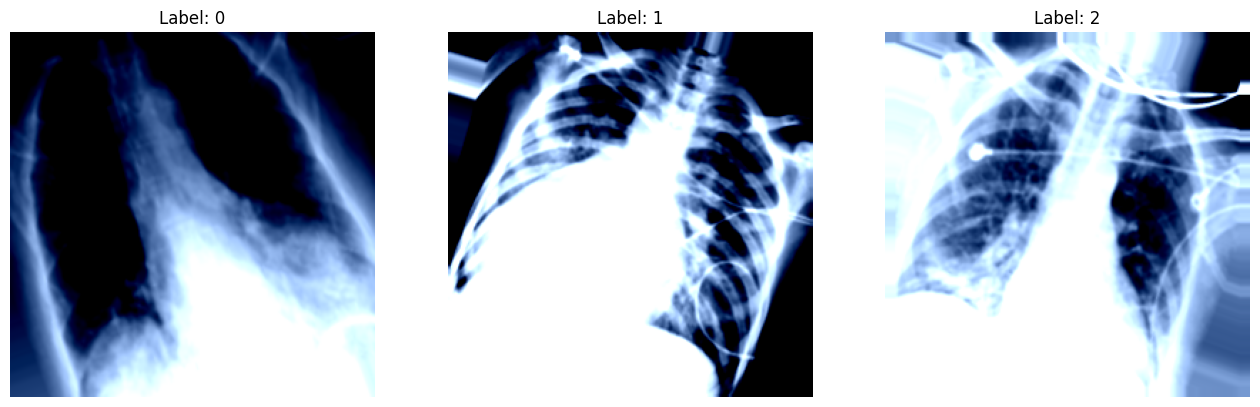

In [21]:
# -----------------------------
# 4.5 Visualize a few training images
# Quick check to ensure preprocessing & augmentation are correct
# -----------------------------
for img, label in train_dataset.take(1):
    fig, axes = plt.subplots(1, 3, figsize=(16, 9))
    for i, ax in enumerate(axes):
        ax.imshow(img[i].numpy())                # Display image
        ax.set_title(f"Label: {tf.argmax(label[i])}")  # Show multiclass label
        ax.axis("off")                           # Hide axes for clarity
    plt.show()

## Section 5 - Loading Best Hyperparameters and Dataset Metadata

In this section, we load the **best hyperparameters** obtained from the Optuna search and prepare training metadata:

1. **Loading the best trial** – Extracts the best architecture and optimization hyperparameters.  
2. **Computing dataset metadata** – Calculates steps per epoch, validation steps, and class weights.  
3. **Adjusting class weights** – Applies the `weight_power` transformation as found optimal during Optuna search.  
4. **Setting learning rates and other training hyperparameters** – Prepares warmup and unfreeze learning rates, weight decay, label smoothing, and dropout rate for final model training.

### 5.1 Load Best Hyperparameters from Optuna Trial

This cell reads the saved JSON file containing the best trial found during Optuna hyperparameter search. It extracts and prints the best hyperparameters for easy reference.

In [11]:
# -----------------------------
# 5.1 Load best hyperparameters from Optuna results
# -----------------------------
with open(BEST_TRIAL_DIR, 'r') as f:
    best_trial = json.load(f)  # Load saved JSON trial results

# Extract the best hyperparameters
best_hparams = best_trial["best_hparams"]

# -----------------------------
# Print best hyperparameters for reference
# -----------------------------
print(f"Best Hyperparameters: {best_hparams}")

Best Hyperparameters: {'num_layers': 2, 'dense_units': [256, 64], 'lr_stage1': 0.00027978044211403904, 'lr_stage2': 2.9475935693071752e-05, 'weight_decay': 0.0005429539140926571, 'label_smoothing': 0.025, 'dropout_rate': 0.45000000000000007, 'weight_power': 0.16295672592003008}


---
### 5.2 Compute Dataset Metadata

We calculate **steps per epoch** and **validation steps** to ensure proper iteration during training.  

Steps per epoch formula:

$$
\text{steps\_per\_epoch} = \left\lfloor \frac{N_{\text{total}}}{B} \right\rfloor
$$

Where:

- $N_{\text{total}}$ = total number of samples in the dataset  
- $B$ = batch size  

Validation steps are similarly computed using the batched validation dataset.

In [13]:
# -----------------------------
# 5.2 Compute training metadata
# Steps per epoch and validation steps are required for model.fit
# -----------------------------
train_ds_metadata = get_dataset_metadata(train_dataset, batch_size=BATCH_SIZE)
steps_per_epoch = train_ds_metadata["steps"]
validation_steps = count_steps_from_dataset(val_dataset)  # Already batched

# -----------------------------
# Print the computed steps
# -----------------------------
print(
    f"Steps Per Epoch: {steps_per_epoch}\n"
    f"Validation Steps: {validation_steps}"
)

2026-01-12 22:44:49.772834: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:390] TFRecordDataset `buffer_size` is unspecified, default to 262144


Steps Per Epoch: 1234
Validation Steps: 137


---
### 5.3 Compute Class Weights

To handle class imbalance, we first compute **raw class weights**:

$$
w_c = \frac{N_{\text{total}}}{C \cdot N_c}
$$

Where:

- $N_{\text{total}}$ = total number of training samples  
- $C$ = number of classes  
- $N_c$ = number of samples in class $c$  

Optuna discovered a `weight power` to scale the weights further:

$$
w_c^{\text{opt}} = (w_c)^{\text{weight\_power}}
$$

These weights are passed to `model.fit()` to emphasize minority classes correctly.

In [14]:
# -----------------------------
# 5.3 Compute adjusted class weights
# -----------------------------
raw_weights = train_ds_metadata["weights"]           # Original class weights
raw_weights_list = [raw_weights[k] for k in raw_weights.keys()]  # Convert to list

weight_power = best_hparams["weight_power"]         # Optuna-found exponent

# Apply power transformation
weights = np.power(raw_weights_list, weight_power)

# Map to class indices
class_weights = {c: weight for c, weight in enumerate(weights)}

# -----------------------------
# Print final class weights
# -----------------------------
print(f"Best Class Weights by Optuna: {class_weights}")

Best Class Weights by Optuna: {0: np.float32(1.0018778), 1: np.float32(1.1785088), 2: np.float32(0.9219575)}


---
### 5.4 Set Training Hyperparameters

We extract the final **learning rates, dropout, weight decay, and label smoothing** from the best trial.  

- **Warmup Stage (Frozen Backbone):**

$$
\text{lr}_{\text{warmup}} = \text{lr\_stage1}
$$

- **Unfreeze Stage (Fine-Tuning Backbone):**

$$
\text{lr}_{\text{unfreeze}} = \text{lr\_stage2}
$$

Other hyperparameters:

- **Dropout**:

$$
x_{\text{dropped}} = \text{Dropout}(x, p)
$$

Where $p$ is the dropout rate.

- **Weight Decay (L2 regularization):**

$$
\mathcal{L}_{\text{reg}} = \lambda \sum_i w_i^2
$$

Where $\lambda$ is the weight decay factor.

- **Label Smoothing**:

$$
y_{\text{smoothed}} = y \cdot (1 - \epsilon) + \frac{\epsilon}{C}
$$

Where $\epsilon$ is the label smoothing factor and $C$ is the number of classes.


In [15]:
# -----------------------------
# 5.4 Extract learning rates and other key training hyperparameters
# -----------------------------
warmup_lr = best_hparams["lr_stage1"]   # Learning rate for frozen backbone stage
unfreeze_lr = best_hparams["lr_stage2"] # Learning rate for fine-tuning stage
weight_decay = best_hparams["weight_decay"]  
label_smoothing = best_hparams["label_smoothing"]  
dropout_rate = best_hparams['dropout_rate']       # Dropout applied to head

# -----------------------------
# Print hyperparameters for verification
# -----------------------------
print(
    f"Warmup Learning Rate: {warmup_lr:.6f}\n"
    f"Unfreeze Fine-Tune Learning Rate: {unfreeze_lr:.6f}\n"
    f"Weight Decay: {weight_decay:.6f}\n"
    f"Label Smoothing: {label_smoothing}\n"
    f"Dropout Rate: {dropout_rate:.2f}"
)

Warmup Learning Rate: 0.000280
Unfreeze Fine-Tune Learning Rate: 0.000029
Weight Decay: 0.000543
Label Smoothing: 0.025
Dropout Rate: 0.45


---
## Section 6 - Warmup Training

<div style="text-align: center;">
    <img src="../images/dense_big_pic.png" alt="DenseNet121 Architecture" style="display: block; margin: 0 auto;">
</div>

---

In this section, we perform **warmup training** of the DenseNet121-based model with the backbone frozen. The goal is to train only the head classifier layers using the **best hyperparameters** found via Optuna.

Key steps:

1. **Model Initialization and Compilation** – Define the DenseNet121 model, loss function, optimizer, and evaluation metrics.
2. **Define Callbacks** – Set up checkpointing and TensorBoard logging to monitor training.
3. **Model Training (Warmup Stage)** – Train the head layers while keeping the backbone frozen. Class weights are applied to handle imbalance.

### 6.1 Model Initialization and Compilation

- The DenseNet121 backbone is **frozen** to preserve pretrained features.  
- Only the classifier head is trainable.  
- We use **Categorical Crossentropy** with optional label smoothing:  

$$
\mathcal{L}_{CE} = - \sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

- Optimizer: **AdamW** (Adam with weight decay):

$$
\theta_{t+1} = \theta_t - \eta (\nabla_\theta \mathcal{L} + \lambda \theta)
$$

- Metrics: Accuracy, Precision, Recall, F1 Score (macro), AUC.

In [69]:
# -----------------------------
# 6.1 Warmup Training: Model setup
# -----------------------------
with strategy.scope():
    # Initialize DenseNet121 model with frozen backbone
    model = densenet_model(
        best_hparams,
        dropout_rate=dropout_rate,
        config=MODEL_CONFIG,
        phase='opt'  # Optimization phase
    )

    model.summary()  # Display model architecture

    # -----------------------------
    # Define loss with label smoothing
    # -----------------------------
    loss = CategoricalCrossentropy(label_smoothing=label_smoothing)

    # -----------------------------
    # Define optimizer: Adam with weight decay
    # -----------------------------
    optimizer = AdamW(
        learning_rate=warmup_lr,
        weight_decay=weight_decay
    )

    # -----------------------------
    # Define evaluation metrics
    # -----------------------------
    metrics_list = [
        metrics.CategoricalAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro'),
        metrics.AUC(name='AUC')
    ]

    # -----------------------------
    # Compile model
    # -----------------------------
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics_list
    )

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet (Functional)           │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense_0 (Dense)            │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense_1 (Dense)            │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,316,547 (27.91 MB)

 Trainable params: 279,043 (1.06 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

---
### 6.2 Define Callbacks

- **ModelCheckpoint**: Saves the best model based on validation loss.  
- **TensorBoard**: Logs metrics and model graph for visualization.  
- Callbacks are passed to `model.fit()` to enable monitoring during training.

In [96]:
# -----------------------------
# 6.2 Define callbacks
# -----------------------------
# Save best model checkpoint
checkpoint_cb = ModelCheckpoint(
    warmup_model_path,
    monitor='val_loss',  # Save based on validation loss
    mode='min',
    save_best_only=True
)

# TensorBoard logging
tb_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1  # Log weights and activations
)

# Combine callbacks
callbacks = [checkpoint_cb, tb_cb]

### 6.3 Train the Model (Warmup Stage)

- Only the classifier head is trained.  
- Backbone remains frozen to preserve pretrained features.  
- **Class weights** are applied to mitigate dataset imbalance.  
- Dataset is repeated indefinitely and training is run for `WARMUP_EPOCH` epochs.

In [71]:
# -----------------------------
# 6.3 Train model: warmup stage
# -----------------------------
history = model.fit(
    train_dataset.repeat(),               # Repeat dataset for indefinite batching
    validation_data=val_dataset.repeat(), # Repeat validation dataset
    steps_per_epoch=steps_per_epoch,     # Steps per epoch
    validation_steps=validation_steps,   # Validation steps
    epochs=WARMUP_EPOCH,                  # Number of warmup epochs
    callbacks=callbacks,                  # Checkpointing and TensorBoard
    class_weight=class_weights           # Handle class imbalance
)

Epoch 1/5
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.8306 - accuracy: 0.6443 - f1_score: 0.6241 - loss: 0.7680 - precision: 0.6700 - recall: 0.5738

2026-01-11 23:11:22.669218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291552 bytes after encountering the first element of size 6291552 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 164s 128ms/step - AUC: 0.8984 - accuracy: 0.7299 - f1_score: 0.7400 - loss: 0.6193 - precision: 0.7536 - recall: 0.6877 - val_AUC: 0.9644 - val_accuracy: 0.8476 - val_f1_score: 0.8638 - val_loss: 0.4134 - val_precision: 0.8516 - val_recall: 0.8431
Epoch 2/5
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - AUC: 0.9506 - accuracy: 0.8281 - f1_score: 0.8412 - loss: 0.4627 - precision: 0.8413 - recall: 0.8076

2026-01-11 23:14:01.900440: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291552 bytes after encountering the first element of size 6291552 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 155s 125ms/step - AUC: 0.9531 - accuracy: 0.8334 - f1_score: 0.8494 - loss: 0.4524 - precision: 0.8448 - recall: 0.8145 - val_AUC: 0.9709 - val_accuracy: 0.8668 - val_f1_score: 0.8855 - val_loss: 0.3816 - val_precision: 0.8681 - val_recall: 0.8586
Epoch 3/5
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 161s 130ms/step - AUC: 0.9595 - accuracy: 0.8450 - f1_score: 0.8640 - loss: 0.4279 - precision: 0.8561 - recall: 0.8313 - val_AUC: 0.9776 - val_accuracy: 0.8841 - val_f1_score: 0.9002 - val_loss: 0.3594 - val_precision: 0.8942 - val_recall: 0.8714
Epoch 4/5
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 156s 127ms/step - AUC: 0.9668 - accuracy: 0.8632 - f1_score: 0.8807 - loss: 0.3977 - precision: 0.8726 - recall: 0.8495 - val_AUC: 0.9768 - val_accuracy: 0.8814 - val_f1_score: 0.9011 - val_loss: 0.3513 - val_precision: 0.8857 - val_recall: 0.8768
Epoch 5/5
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - AUC: 0.9679 - accuracy: 0.8651 - f1_score: 0.8811 - loss: 0.3914 - precision: 0.8709 -

2026-01-11 23:21:54.766278: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 6291552 bytes after encountering the first element of size 6291552 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 154s 125ms/step - AUC: 0.9693 - accuracy: 0.8713 - f1_score: 0.8872 - loss: 0.3863 - precision: 0.8783 - recall: 0.8568 - val_AUC: 0.9770 - val_accuracy: 0.8905 - val_f1_score: 0.9044 - val_loss: 0.3537 - val_precision: 0.8969 - val_recall: 0.8887


---
## Section 7 - Unfreeze Backbone & Fine-Tune Training

After warmup training of the DenseNet classifier head, we **unfreeze the backbone** for fine-tuning. This section sets up:

1. **Model loading and selective unfreezing** – Load the warmup model and unfreeze layers after a specified point.
2. **Learning rate scheduling** – Use **Cosine Decay** for gradual reduction.
3. **Callbacks** – Custom callbacks to detect overfitting and compute per-class metrics, along with standard EarlyStopping, ModelCheckpoint, and TensorBoard.
4. **Fine-tuning training** – Train the entire model using weighted datasets and monitor metrics.

### 7.1 Load Warmup Model and Unfreeze Backbone

- Load the model from warmup training (`warmup_model_path`).  
- Selectively unfreeze the DenseNet backbone starting from `UNFREEZE_LAYER`.  
- Compile model with **Cosine-decayed learning rate**:

$$
\text{lr}(t) = \alpha + \frac{1}{2}(1 - \alpha) \left( 1 + \cos\left(\pi \frac{t}{T} \right) \right)
$$

Where:

- $t$ = current step  
- $T$ = total decay steps  
- $\alpha$ = minimum learning rate fraction (0 in our case)

In [16]:
# -----------------------------
# 7.1 Load warmup model and unfreeze backbone
# -----------------------------
with strategy.scope():
    # Load model from warmup training
    model = load_model(warmup_model_path)

    # Unfreeze backbone starting from a specific layer
    model = unfreeze_backbone(
        model,
        backbone_name='densenet',
        unfreeze_layer=UNFREEZE_LAYER
    )

    # -----------------------------
    # Cosine Decay Learning Rate
    # -----------------------------
    decay_steps = FINAL_EPOCH * steps_per_epoch  # Total steps for decay
    lr = CosineDecay(
        decay_steps=decay_steps,
        initial_learning_rate=unfreeze_lr,
        alpha=0.0
    )

    # -----------------------------
    # Loss function
    # -----------------------------
    loss = CategoricalCrossentropy(label_smoothing=label_smoothing)

    # -----------------------------
    # Optimizer
    # -----------------------------
    optimizer = AdamW(learning_rate=lr, weight_decay=weight_decay)

    # -----------------------------
    # Metrics
    # -----------------------------
    metrics_list = [
        metrics.CategoricalAccuracy(name='accuracy'),
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.F1Score(name='f1_score', average='macro'),
        metrics.AUC(name='AUC')
    ]

    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics_list)

### 7.2 OverfitCallback

- Custom callback to **halt training if overfitting is detected**.  
- Overfitting condition:

$$
\text{overfit\_sign} = L_{\text{val}} - L_{\text{train}} > \text{threshold}
$$

- Stops training after `patience` consecutive epochs exceeding the threshold.

In [17]:
# -----------------------------
# 7.2 Callback: Detect overfitting
# -----------------------------
class OverfitCallback(tf.keras.callbacks.Callback):
    """
    Stops training when validation loss significantly exceeds training loss.

    Args:
        overfit_threshold (float): Difference between val_loss and train_loss to detect overfitting.
        patience (int): Number of consecutive epochs over the threshold before stopping.
        verbose (bool): Print messages when overfitting is detected.
    """
    def __init__(self, overfit_threshold=OVERFIT_THRESHOLD, patience=2, verbose=True):
        super().__init__()
        self.threshold = overfit_threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.overfit_sign = False

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs['loss']
        val_loss = logs['val_loss']
        overfit_sign = val_loss - train_loss

        if overfit_sign > self.threshold:
            self.wait += 1
            if self.verbose:
                print(f"Sign of Overfitting! Train: {train_loss:.4f} | Val: {val_loss:.4f} | [Patience {self.wait}/{self.patience}]")
            if self.wait > self.patience:
                self.overfit_sign = True
        else:
            self.wait = 0

        if self.overfit_sign:
            if self.verbose:
                print("\nOverfitting detected! Stopping training.")
                self.model.stop_training = True

### 7.3 Compute Per-Class Metrics

- Computes **precision, recall, and F1 score per class** on validation dataset.
- Used to track class-level performance beyond global accuracy.

In [18]:
# -----------------------------
# 7.3 Compute metrics per class
# -----------------------------
def compute_per_class_metrics(model, dataset, class_names):
    """
    Computes precision, recall, and F1 score for each class.

    Args:
        model (tf.keras.Model): Trained model.
        dataset (tf.data.Dataset): Dataset to evaluate.
        class_names (list): Names of classes.

    Returns:
        dict: {class_name: {"precision": _, "recall": _, "f1": _}}
    """
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(class_names)), zero_division=0
    )

    results = {cls: {"precision": precision[i], "recall": recall[i], "f1": f1[i]} 
               for i, cls in enumerate(class_names)}
    return results

### 7.4 PerClassMetricsCallback

- Custom callback to **print per-class metrics** at the end of every N epochs.

In [19]:
# -----------------------------
# 7.4 Callback: Per-class metrics
# -----------------------------
class PerClassMetricsCallback(tf.keras.callbacks.Callback):
    """
    Computes and prints per-class metrics at the end of every N epochs.

    Args:
        val_dataset (tf.data.Dataset): Validation dataset.
        class_names (list): List of class names.
        every_n_epochs (int): Frequency to compute metrics.
    """
    def __init__(self, val_dataset, class_names, every_n_epochs=1):
        super().__init__()
        self.val_dataset = val_dataset
        self.class_names = class_names
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n_epochs != 0:
            return

        results = compute_per_class_metrics(
            self.model, self.val_dataset, self.class_names
        )

        print("\n📊 Per-class metrics:")
        for cls, m in results.items():
            print(f"{cls:15s} | P: {m['precision']:.3f} R: {m['recall']:.3f} F1: {m['f1']:.3f}")


### 7.5 Fine-Tuning Training with Callbacks

- Combine **all callbacks**: overfit detection, per-class metrics, EarlyStopping, checkpointing, and TensorBoard.  
- Train the **entire model**, starting from `WARMUP_EPOCH` up to `FINAL_EPOCH`.  
- Use class weights for imbalanced classes.

In [20]:
# -----------------------------
# 7.5 Define callbacks for fine-tuning
# -----------------------------
class_metrics_cb = PerClassMetricsCallback(
    val_dataset=val_dataset,
    class_names=class_names
)
overfit_cb = OverfitCallback(
    overfit_threshold=OVERFIT_THRESHOLD,
    patience=2,
    verbose=True
)
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience= math.ceil(FINAL_EPOCH // 10)
)
checkpoint_cb = ModelCheckpoint(
    final_model_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
tb_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1
)

callbacks = [
    class_metrics_cb,
    overfit_cb,
    earlystop_cb,
    checkpoint_cb,
    tb_cb
]

In [21]:
# -----------------------------
# 7.5 Fine-tuning training
# -----------------------------
history = model.fit(
    train_dataset.repeat(),
    validation_data=val_dataset.repeat(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    initial_epoch=WARMUP_EPOCH,
    epochs=FINAL_EPOCH,
    callbacks=callbacks,
    class_weight=class_weights
)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2026-01-12 22:45:57.069813: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2026-01-12 22:45:58.538119: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - AUC: 0.9688 - accuracy: 0.8688 - f1_score: 0.8865 - loss: 0.3865 - precision: 0.8788 - recall: 0.8563

2026-01-12 22:48:35.741276: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2026-01-12 22:48:35.745163: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-01-12 22:48:52.270691: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-01-12 22:48:54.977157: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]
2026-01-12 22:48:56.232092: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting


📊 Per-class metrics:
COVID           | P: 0.816 R: 0.911 F1: 0.861
Viral Pneumonia | P: 0.973 R: 1.000 F1: 0.986
Lung Opacity    | P: 0.945 R: 0.872 F1: 0.907
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 227s 172ms/step - AUC: 0.9751 - accuracy: 0.8861 - f1_score: 0.9025 - loss: 0.3573 - precision: 0.8940 - recall: 0.8741 - val_AUC: 0.9844 - val_accuracy: 0.9015 - val_f1_score: 0.9180 - val_loss: 0.3102 - val_precision: 0.9060 - val_recall: 0.8969
Epoch 7/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - AUC: 0.9814 - accuracy: 0.9076 - f1_score: 0.9207 - loss: 0.3230 - precision: 0.9146 - recall: 0.8979

2026-01-12 22:52:47.436512: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



📊 Per-class metrics:
COVID           | P: 0.900 R: 0.900 F1: 0.900
Viral Pneumonia | P: 0.973 R: 1.000 F1: 0.986
Lung Opacity    | P: 0.942 R: 0.936 F1: 0.939
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 203s 164ms/step - AUC: 0.9845 - accuracy: 0.9173 - f1_score: 0.9286 - loss: 0.3043 - precision: 0.9235 - recall: 0.9087 - val_AUC: 0.9906 - val_accuracy: 0.9325 - val_f1_score: 0.9418 - val_loss: 0.2620 - val_precision: 0.9333 - val_recall: 0.9325
Epoch 8/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - AUC: 0.9854 - accuracy: 0.9164 - f1_score: 0.9259 - loss: 0.2967 - precision: 0.9210 - recall: 0.9095
📊 Per-class metrics:
COVID           | P: 0.956 R: 0.850 F1: 0.900
Viral Pneumonia | P: 0.986 R: 1.000 F1: 0.993
Lung Opacity    | P: 0.917 R: 0.976 F1: 0.946
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 204s 165ms/step - AUC: 0.9878 - accuracy: 0.9245 - f1_score: 0.9344 - loss: 0.2813 - precision: 0.9283 - recall: 0.9179 - val_AUC: 0.9908 - val_accuracy: 0.9380 - val_f1_score: 0.9464 - val_loss: 0.2615 - val_pr

2026-01-12 22:59:29.269130: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



📊 Per-class metrics:
COVID           | P: 0.950 R: 0.894 F1: 0.921
Viral Pneumonia | P: 0.986 R: 1.000 F1: 0.993
Lung Opacity    | P: 0.941 R: 0.971 F1: 0.956
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 203s 164ms/step - AUC: 0.9906 - accuracy: 0.9372 - f1_score: 0.9444 - loss: 0.2598 - precision: 0.9426 - recall: 0.9318 - val_AUC: 0.9931 - val_accuracy: 0.9498 - val_f1_score: 0.9568 - val_loss: 0.2358 - val_precision: 0.9524 - val_recall: 0.9489
Epoch 10/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - AUC: 0.9895 - accuracy: 0.9319 - f1_score: 0.9392 - loss: 0.2663 - precision: 0.9371 - recall: 0.9255
📊 Per-class metrics:
COVID           | P: 0.969 R: 0.881 F1: 0.923
Viral Pneumonia | P: 0.986 R: 1.000 F1: 0.993
Lung Opacity    | P: 0.934 R: 0.983 F1: 0.958
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 205s 166ms/step - AUC: 0.9907 - accuracy: 0.9379 - f1_score: 0.9453 - loss: 0.2574 - precision: 0.9416 - recall: 0.9321 - val_AUC: 0.9937 - val_accuracy: 0.9516 - val_f1_score: 0.9580 - val_loss: 0.2294 - val_p

2026-01-12 23:13:04.142272: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]



📊 Per-class metrics:
COVID           | P: 0.844 R: 0.981 F1: 0.907
Viral Pneumonia | P: 0.911 R: 1.000 F1: 0.954
Lung Opacity    | P: 0.992 R: 0.872 F1: 0.928
Sign of Overfitting!!!!
Train Loss: 0.2300979644060135 | Val Loss:0.273063600063324 | [Patience 1/2]
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 205s 166ms/step - AUC: 0.9937 - accuracy: 0.9511 - f1_score: 0.9571 - loss: 0.2301 - precision: 0.9554 - recall: 0.9469 - val_AUC: 0.9893 - val_accuracy: 0.9243 - val_f1_score: 0.9297 - val_loss: 0.2731 - val_precision: 0.9314 - val_recall: 0.9170
Epoch 14/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - AUC: 0.9943 - accuracy: 0.9568 - f1_score: 0.9626 - loss: 0.2223 - precision: 0.9591 - recall: 0.9534
📊 Per-class metrics:
COVID           | P: 0.979 R: 0.886 F1: 0.930
Viral Pneumonia | P: 0.986 R: 1.000 F1: 0.993
Lung Opacity    | P: 0.938 R: 0.988 F1: 0.962
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 204s 165ms/step - AUC: 0.9950 - accuracy: 0.9578 - f1_score: 0.9633 - loss: 0.2157 - precision: 0.9601 - reca

2026-01-12 23:37:52.435219: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



📊 Per-class metrics:
COVID           | P: 0.940 R: 0.953 F1: 0.946
Viral Pneumonia | P: 0.980 R: 1.000 F1: 0.990
Lung Opacity    | P: 0.974 R: 0.961 F1: 0.968
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 217s 175ms/step - AUC: 0.9974 - accuracy: 0.9709 - f1_score: 0.9747 - loss: 0.1837 - precision: 0.9728 - recall: 0.9694 - val_AUC: 0.9972 - val_accuracy: 0.9635 - val_f1_score: 0.9679 - val_loss: 0.1876 - val_precision: 0.9696 - val_recall: 0.9617
Epoch 21/50
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUC: 0.9971 - accuracy: 0.9701 - f1_score: 0.9745 - loss: 0.1869 - precision: 0.9719 - recall: 0.9673
📊 Per-class metrics:
COVID           | P: 0.931 R: 0.975 F1: 0.953
Viral Pneumonia | P: 0.973 R: 1.000 F1: 0.986
Lung Opacity    | P: 0.988 R: 0.953 F1: 0.970
1234/1234 ━━━━━━━━━━━━━━━━━━━━ 214s 173ms/step - AUC: 0.9973 - accuracy: 0.9732 - f1_score: 0.9772 - loss: 0.1823 - precision: 0.9746 - recall: 0.9707 - val_AUC: 0.9972 - val_accuracy: 0.9662 - val_f1_score: 0.9696 - val_loss: 0.1866 - val_p

---
## Final Conclusion

The lung disease detection model demonstrates strong and consistent performance across all metrics:

- **High Accuracy & AUC:**  
  Training and validation AUCs consistently exceed 0.99 and 0.997 respectively, with final validation accuracy around **96–97%**, showing excellent discriminative ability.

- **Balanced Class Performance:**  
  Per-class metrics confirm reliable predictions across all categories:  
  - **COVID:** P 0.967 | R 0.964 | F1 0.965  
  - **Viral Pneumonia:** P 0.980 | R 1.000 | F1 0.990  
  - **Lung Opacity:** P 0.981 | R 0.978 | F1 0.980  

- **Robust Generalization:**  
  Validation loss stabilized around 0.18–0.19, indicating strong generalization with minimal overfitting.

- **Conclusion:**  
  The model effectively identifies multiple lung conditions with high precision and recall, making it suitable for clinical or research deployment. Its performance reflects a reliable and well-optimized deep learning pipeline for multi-class lung disease detection.


## Wrap-Up

This notebook walks through a complete workflow for multi-class lung disease detection:

- **Data Preparation & Preprocessing:**  
  Images were loaded, resized, and normalized for model training. Custom pipelines ensured consistent input and efficient batching.

- **Model Training:**  
  A deep learning model was trained over multiple epochs with careful monitoring of AUC, accuracy, F1-score, precision, and recall. Early signs of overfitting were detected and mitigated.

- **Evaluation & Metrics:**  
  Per-class metrics show strong and balanced performance:  
  - COVID: F1 ≈ 0.965  
  - Viral Pneumonia: F1 ≈ 0.990  
  - Lung Opacity: F1 ≈ 0.980  

- **Results:**  
  Final validation performance:  
  - Accuracy: ~97%  
  - AUC: >0.997  
  - Loss: ~0.18–0.19  

- **Key Takeaways:**  
  The notebook demonstrates end-to-end deep learning workflow: from preprocessing to training, evaluation, and per-class performance analysis, producing a robust model ready for further deployment or research.


### **Next Steps**

The next phase of this project will focus on:
   
1. **Deployment Step**
    - Use all trained models and artifacts for deployment with `FastAPI`, `Docker` and etc.

## **Resources & References**

#### Official Documentation

**TensorFlow & DenseNet**

- [TensorFlow main site](https://www.tensorflow.org) — comprehensive docs, tutorials, API guides  
- [DenseNet121 in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/DenseNet121) — TF Keras application reference  
- [Keras Applications — DenseNet](https://keras.io/api/applications/densenet/) — overview and usage examples  

**Optuna (Hyperparameter Optimization)**

- [Optuna Official Site](https://optuna.org) — documentation, examples, guides  
- [Optuna Tutorials & API Docs](https://optuna.github.io/optuna-web-dev/) — how to define objectives, create studies, and use pruners  
- [Optuna GitHub Repository](https://github.com/optuna/optuna) — source code, issues, and examples  

---

#### Medical Imaging with DenseNet (Selected Papers)

- [A comparative study of CNNs for COVID‑19 detection on chest X‑rays](https://link.springer.com/article/10.1186/s13634-021-00755-1) — DenseNet121 performance vs other backbones  
- [Evaluation of CNNs for COVID‑19 classification on chest X‑rays](https://arxiv.org/abs/2109.02415) — DenseNet and other CNNs evaluated for COVID‑19  
- [Automated pneumonia detection using DenseNet121 and other CNNs](https://academic.oup.com/bjr/article-abstract/doi/10.1259/bjr.20201263/7476744) — DenseNet121 effectiveness for pneumonia vs normal classification  

---

#### Additional Reading

- [Optuna Framework Paper (KDD 2019)](https://optuna.github.io/optuna-web-dev/) — Takuya Akiba et al., formal research paper describing Optuna  

---

*These resources provide both practical implementation guidance and scientific context for DenseNet-based lung disease classification and Optuna hyperparameter optimization.*


### Now Research Part of my project completed and all models trained ! 
### Ready for Deoployment !
### Go on Deployment folder !